In this tutorial, we'll use the following techniques to train a state-of-the-art model in less than 5 minutes to achieve over 90% accuracy in classifying images from the CIFAR10 dataset:

⚫ Data normalization

⚫ Data augmentation

Residual connections

Batch normalization

⚫ Learning rate scheduling

Weight Decay

Gradient clipping

. Adam optimizer

Classifiying CIFAR10 images using resNets, Regularization and Data Augmentation in pytorch

In [1]:
import os

import torch

import torchvision

import tarfile

import torch.nn as nn

import numpy as np

import torch.nn. functional as F

from torchvision.datasets.utils import download_url

from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader

import torchvision.transforms as tt

from torch.utils.data import random_split

from torchvision.utils import make_grid

import matplotlib

import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name = 'Cifar10-resnet'

In [3]:
#download the dataset

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')


100%|██████████| 135107811/135107811 [00:04<00:00, 29773126.59it/s]


In [4]:
# extract from archive

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test']
['bird', 'airplane', 'horse', 'deer', 'automobile', 'cat', 'truck', 'frog', 'dog', 'ship']


we can create trainnig and validation datasets using the ImageFolder class form trochvision. in addition to the ToTensor transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. Use test set for validation: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation'set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.

2. Channel-wise data normalization: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3. Randomized data augmentations: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [5]:
 # data transforms (normalization & data augmentation)
 stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
 train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                          tt.RandomHorizontalFlip(),
                          tt.ToTensor(),
                          tt.Normalize(*stats, inplace=True)])
 valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [6]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+ '/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test',valid_tfms)

Next, we can create data loaders for retrieving images in batches. we will use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. you can try reducing the batch size & restarting the kernel if you face an "out of memory" error


In [7]:
batch_size = 400



In [8]:

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))      # permute>>> change the colorchannel position to the last one.
    break

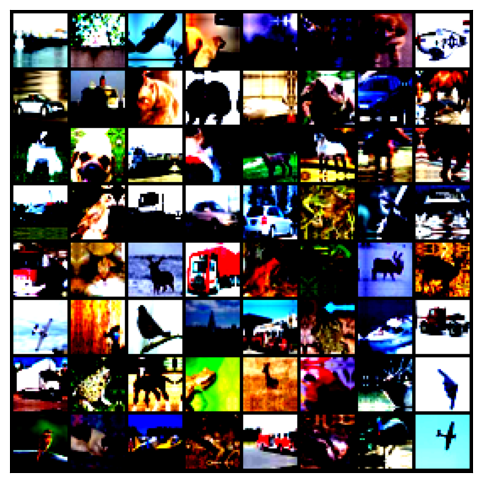

In [10]:
show_batch(train_dl)

the colors semm out of place because of the normalization. Note that normalization is also applied during inference.if you look closely you can see the cropping and reflection padding in soe of the images horizontal flip is a bit difficult to detect from visual inspection

###Using GPUs

In [11]:
def get_default_device():
  """ Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device=device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [12]:

device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

###Model with Residual blocks and Batch Normalization




one of the key changes to our cnn model this time is the addition of the resudial block which adds the original input back tothe output fesature map obtained by passing the input through on eor more convolutional layers


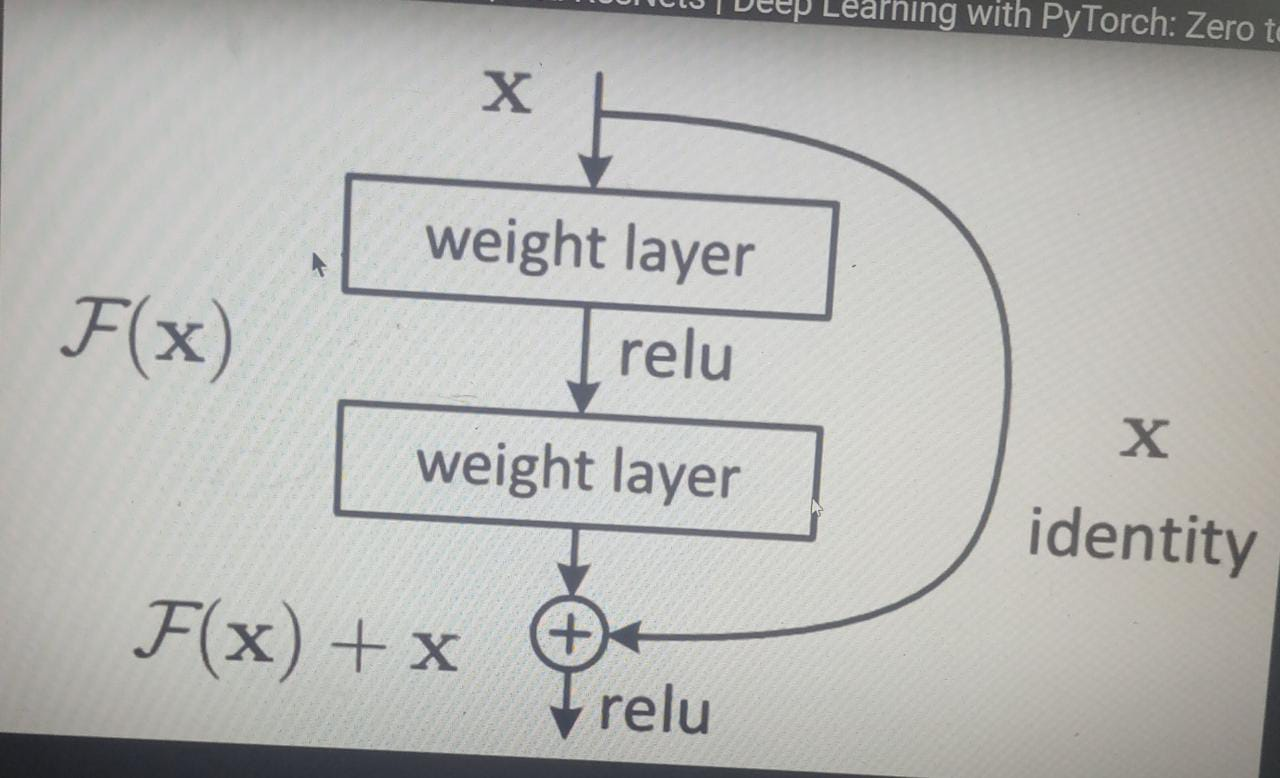

here is a very simple residual block:


In [14]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(x)
    return self.relu2(out) + x  # ReLU can applied before or after adding the initial value of x




In [15]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
  print(images.shape)
  out = simple_resnet(images)
  print(out.shape)
  break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


this seeming small change produces a drastic improvement in the performance of the model. also after each convolutional layer we will add a batch normalization layer, which nomalizes the outputs of the previous layer

#we will use the ResNet9 architecture

In [16]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassifictionBase(nn.Module):
  def training_step(self , batch):
    images, labels = batch
    out = self(images)                        # Generate predictions
    loss = F.cross_entropy(out, labels)       # Calculate loss
    return loss

  def validation_step(self , batch):
    images, labels = batch
    out = self(images)                        # Generate predictions
    loss = F.cross_entropy(out, labels)       # calaculate loss
    acc = accuracy(out , labels)              # calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}


  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     # combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        # combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f},  val_loss: {:.4f}, val_acc: {:.4}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [30]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassifictionBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    # 3 , 32, 32
    self.conv1 = conv_block(in_channels, 64)  # 64, 32 ,32
    self.conv2 = conv_block(64, 128, pool=True) # 128, 16,16
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))


    self.conv3 = conv_block(128, 256, pool=True) # 256, 8, 8
    self.conv4 = conv_block(256, 512, pool=True) # 512, 4, 4
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))


    self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512, 1, 1
                                    nn.Flatten(),    # 512
                                    nn.Linear(512, num_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) - out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) - out
    out = self.classifier(out)
    return out



In [31]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our fit function

Leaming rate scheduling: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the leaming rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning matte for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://squgger.github.io/the-1cycle-policy.html

Weight decay. We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

Gradient clipping: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more:

let's define fit_one_cycle function to incorporate these changes. we will also record the learning rate used for each batch.

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
  """Evaluate the model's performance on the validation set"""
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']



def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  """Train the model using gradient descent"""
  torch.cuda.empty_cache()     # to clear the cache
  history=[]
  # set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
    #Training Phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # record & update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['lrs']=lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [33]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3023056983947754, 'val_acc': 0.09692308306694031}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [34]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip= grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], train_loss: 1.3112,  val_loss: 1.2452, val_acc: 0.5938
Epoch [1], train_loss: 0.9103,  val_loss: 1.1818, val_acc: 0.6388
Epoch [2], train_loss: 0.7633,  val_loss: 0.7227, val_acc: 0.7421
Epoch [3], train_loss: 0.6182,  val_loss: 0.6023, val_acc: 0.7989
Epoch [4], train_loss: 0.5346,  val_loss: 0.5974, val_acc: 0.7996
Epoch [5], train_loss: 0.4693,  val_loss: 0.5080, val_acc: 0.8263
Epoch [6], train_loss: 0.3985,  val_loss: 0.4897, val_acc: 0.8372
Epoch [7], train_loss: 0.3061,  val_loss: 0.3798, val_acc: 0.8727
Epoch [8], train_loss: 0.2216,  val_loss: 0.2826, val_acc: 0.9043
Epoch [9], train_loss: 0.1704,  val_loss: 0.2670, val_acc: 0.9095
CPU times: user 27 s, sys: 5.74 s, total: 32.8 s
Wall time: 6min 35s


In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch No.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.')

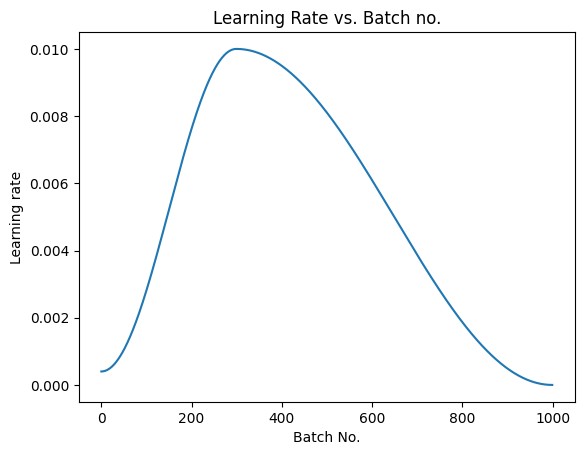

In [ ]:
plot_lrs(history)

###Testing with individual images

In [ ]:

def predict_image(img, model):
    #Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _,  preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label:  airplane , predicted: airplane


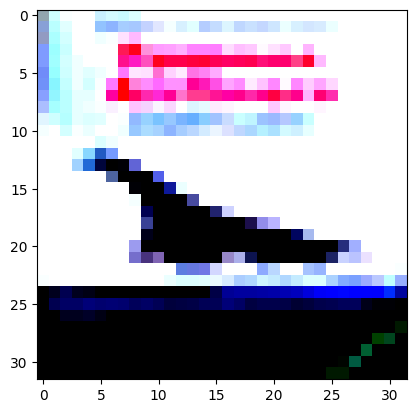

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', train_ds.classes[label], ', predicted:', predict_image(img, model))

Label:  airplane , predicted: airplane


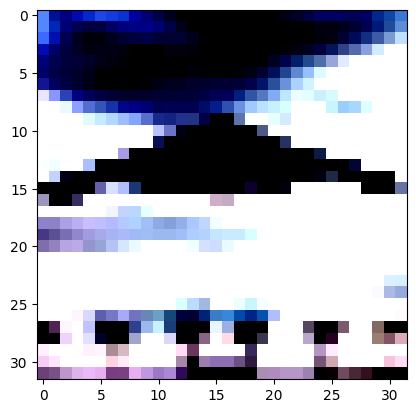

In [ ]:
img, label = valid_ds[10]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', train_ds.classes[label], ', predicted:', predict_image(img, model))